# Hamburg Appartement Market Data Analysis and Modelling

<br>

### What factors impact the price the most?

<br>

#### 1. Which neighborhood has the highest impact?
#### 2. How do space and the number of rooms relate to the price?
#### 3. How do private offers impact the price?
#### 4. How do other factors impact the price?

### Importing packages

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

### Reading in the data

In [2]:
#the data comes from different excel files I scraped over a few months.
files = []
frames = []

for f in glob.glob(".\Data\*.xlsx"):
    files.append(f)
    frames.append(pd.read_excel(f, sheet_name="Sheet1"))

df = pd.concat(frames)

In [3]:
df.shape

(71767, 21)

In [4]:
df.head()

,ID,Haus/Wohnung,ID.1,Miete/Kauf,address,balcony,builtInKitchen,city,floorplan,from,...,lat,livingSpace,lon,numberOfRooms,postcode,price,privateOffer,quarter,title,url
0,107053440,Wohnung,107053440,Kauf,"Julius-Vosseler-Strasse 82a, Lokstedt, Hamburg",True,False,Hamburg,False,001.507379,...,53.59171,43.67,9.94497,2.0,22527,272937.5,False,Lokstedt,Eigentumswohnungen in Hamburg-Lokstedt,https://www.immobilienscout24.de/expose/107053440
1,109298032,Wohnung,109298032,Kauf,"Ohlsdorf, Hamburg",True,False,Hamburg,True,002.01004919249,...,NaN,117.00,NaN,4.0,22335,629800.0,False,Ohlsdorf,"629.800 €, 117 m², 4 Zimmer",https://www.immobilienscout24.de/expose/109298032
2,108673845,Wohnung,108673845,Kauf,"Alsterufer 10, Rotherbaum, Hamburg",False,False,Hamburg,False,001.5759162,...,53.56033,231.00,9.99611,5.0,20354,3520000.0,False,Rotherbaum,THE 10 - Luxury Flat mit Alsterblick für die F...,https://www.immobilienscout24.de/expose/108673845
3,108673576,Wohnung,108673576,Kauf,"Barmbek-Nord, Hamburg",True,True,Hamburg,True,001.5759162,...,NaN,97.00,NaN,3.0,22305,549000.0,False,Barmbek-Nord,Moderne 3-Zimmer-Wohnung mit Weitblick,https://www.immobilienscout24.de/expose/108673576
4,107298572,Wohnung,107298572,Kauf,"Grete-Zabe-Weg 13, Barmbek-Süd, Hamburg",True,False,Hamburg,True,001.177210,...,53.57751,64.43,10.05623,2.0,22081,398000.0,False,Barmbek-Süd,Citynah mit Blick ins Grüne: 2 Zimmer mit XL B...,https://www.immobilienscout24.de/expose/107298572


### Preprocessing the data

In [5]:
#I often sraped the data on censecutive days which results in duplicates
#I use the "ID" to identify the duplicates and drop them
dfu = df.drop_duplicates(subset="ID")

In [6]:
dfu.shape

(8712, 21)

In [7]:
#dropping columns I wont need.
dfu = dfu.drop(columns=["ID.1", "from", "title", "url", "Haus/Wohnung", "Miete/Kauf"])
dfu.head()

,ID,address,balcony,builtInKitchen,city,floorplan,garden,lat,livingSpace,lon,numberOfRooms,postcode,price,privateOffer,quarter
0,107053440,"Julius-Vosseler-Strasse 82a, Lokstedt, Hamburg",True,False,Hamburg,False,False,53.59171,43.67,9.94497,2.0,22527,272937.5,False,Lokstedt
1,109298032,"Ohlsdorf, Hamburg",True,False,Hamburg,True,True,NaN,117.00,NaN,4.0,22335,629800.0,False,Ohlsdorf
2,108673845,"Alsterufer 10, Rotherbaum, Hamburg",False,False,Hamburg,False,False,53.56033,231.00,9.99611,5.0,20354,3520000.0,False,Rotherbaum
3,108673576,"Barmbek-Nord, Hamburg",True,True,Hamburg,True,False,NaN,97.00,NaN,3.0,22305,549000.0,False,Barmbek-Nord
4,107298572,"Grete-Zabe-Weg 13, Barmbek-Süd, Hamburg",True,False,Hamburg,True,False,53.57751,64.43,10.05623,2.0,22081,398000.0,False,Barmbek-Süd


In [8]:
dfu = dfu.set_index("ID")

In [9]:
#looking for missing data
dfu.isnull().sum().sort_values(ascending=False)

lon               6305
lat               6305
quarter              0
privateOffer         0
price                0
postcode             0
numberOfRooms        0
livingSpace          0
garden               0
floorplan            0
city                 0
builtInKitchen       0
balcony              0
address              0
dtype: int64

In [10]:
#I will drop lon and lat because there are too many missing values
dfu = dfu.drop(columns=["lon", "lat"])

In [11]:
#since price is the value I want to predict I need to look for extreme values
dfu[dfu["price"] <= 10000]

,address,balcony,builtInKitchen,city,floorplan,garden,livingSpace,numberOfRooms,postcode,price,privateOffer,quarter
ID,,,,,,,,,,,,
108878995,"Halstenbek, Pinneberg (Kreis)",True,False,Pinneberg (Kreis),True,False,90.73,3.0,25469,0.0,False,Halstenbek
94489310,"Wedel, Pinneberg (Kreis)",False,False,Pinneberg (Kreis),True,False,110.00,3.0,22880,0.0,False,Wedel
111339556,"Eppendorf, Hamburg",True,True,Hamburg,True,False,141.00,5.0,20249,0.0,False,Eppendorf
114564342,"Poppenbüttel, Hamburg",True,True,Hamburg,True,True,400.00,6.0,22391,0.0,False,Poppenbüttel
114924254,"Moordamm xx, Kiebitzreihe, Steinburg (Kreis)",True,False,Steinburg (Kreis),False,False,35.00,1.0,25368,7000.0,False,Kiebitzreihe
114670286,"Moordamm 1, Kiebitzreihe, Steinburg (Kreis)",True,False,Steinburg (Kreis),False,False,35.00,1.0,25368,7000.0,False,Kiebitzreihe
115657655,"Bad Segeberg, Segeberg (Kreis)",True,True,Segeberg (Kreis),True,False,78.46,3.0,23795,0.0,False,Bad Segeberg
115954786,"Winterhude, Hamburg",False,False,Hamburg,True,False,78.00,3.0,22299,0.0,False,Winterhude
116564683,"Bad Segeberg, Segeberg (Kreis)",True,True,Segeberg (Kreis),True,False,78.46,3.0,23795,0.0,False,Bad Segeberg


In [12]:
#I should filter flats with a price of 0.
dfu = dfu[dfu["price"] != 0]

In [13]:
#since price is the value I want to predict I need to look for extreme values
dfu[dfu["price"] >= 10000000]

,address,balcony,builtInKitchen,city,floorplan,garden,livingSpace,numberOfRooms,postcode,price,privateOffer,quarter
ID,,,,,,,,,,,,
116865363,"Jenfeld, Hamburg",False,False,Hamburg,False,False,2000.0,39.0,22043,10100000.0,False,Jenfeld


In [14]:
#I should filter flats with a price above 10,000,000.
dfu = dfu[dfu["price"] <= 10000000]

In [15]:
dfu.price

ID
107053440     272937.5
109298032     629800.0
108673845    3520000.0
108673576     549000.0
107298572     398000.0
               ...    
119169178     249000.0
119197429     179000.0
119115381     237000.0
119113517     345000.0
119152632     595000.0
Name: price, Length: 8704, dtype: float64

In [16]:
#also I should look for outliers in other numeric fields
#livingSpace
dfu[dfu["livingSpace"] <= 15]

,address,balcony,builtInKitchen,city,floorplan,garden,livingSpace,numberOfRooms,postcode,price,privateOffer,quarter
ID,,,,,,,,,,,,
110550525,"Stellingen, Hamburg",True,True,Hamburg,True,False,0.0,2.5,22527,225000.0,False,Stellingen
116049492,"Eimsbüttel, Hamburg",True,True,Hamburg,True,False,0.0,2.5,20259,420000.0,False,Eimsbüttel
116121486,"Barmbek-Nord, Hamburg",False,False,Hamburg,False,False,3.5,81.0,22337,480000.0,False,Barmbek-Nord
118880235,"Ahrensburg, Stormarn (Kreis)",False,True,Stormarn (Kreis),False,False,0.0,1.0,22926,910000.0,False,Ahrensburg
118939822,"Eppendorf, Hamburg",True,True,Hamburg,True,False,0.0,5.0,20249,1750000.0,False,Eppendorf
119151724,"Wedel, Pinneberg (Kreis)",False,True,Pinneberg (Kreis),True,False,0.0,1.5,22880,135000.0,False,Wedel


In [17]:
dfu = dfu[dfu["livingSpace"] >= 15]

In [18]:
dfu[dfu["livingSpace"] >= 500]
#looks reasonable

,address,balcony,builtInKitchen,city,floorplan,garden,livingSpace,numberOfRooms,postcode,price,privateOffer,quarter
ID,,,,,,,,,,,,
110872406,"Harvestehude, Hamburg",True,True,Hamburg,False,True,537.0,11.0,20149,9950000.0,False,Harvestehude
117410370,"Altona-Altstadt, Hamburg",True,False,Hamburg,True,False,650.0,4.0,22767,3200000.0,False,Altona-Altstadt


In [19]:
#numberOfRooms
dfu[dfu["numberOfRooms"] < 1]
dfu[dfu["numberOfRooms"] >=10]
#looks reasonable

,address,balcony,builtInKitchen,city,floorplan,garden,livingSpace,numberOfRooms,postcode,price,privateOffer,quarter
ID,,,,,,,,,,,,
100319620,"Lauenburg/Elbe, Herzogtum Lauenburg (Kreis)",False,False,Herzogtum Lauenburg (Kreis),True,True,277.50,12.0,21481,250000.0,False,Lauenburg/Elbe
109938370,"Uhlenhorst, Hamburg",True,True,Hamburg,True,True,350.00,10.0,22085,2480000.0,False,Uhlenhorst
104214127,"In den Wettern 49-53, Winsen (Luhe), Harburg (...",True,True,Harburg (Kreis),True,False,410.02,18.0,21423,430000.0,False,Winsen (Luhe)
110872406,"Harvestehude, Hamburg",True,True,Hamburg,False,True,537.00,11.0,20149,9950000.0,False,Harvestehude
111477510,"Marmstorf, Hamburg",True,True,Hamburg,False,False,385.00,15.0,21077,1195000.0,False,Marmstorf
112111131,"Blankenese, Hamburg",True,False,Hamburg,False,True,386.00,11.0,22587,2190000.0,False,Blankenese
113180408,"Wellingsbüttel, Hamburg",True,True,Hamburg,False,False,474.45,11.0,22391,2800000.0,False,Wellingsbüttel
113607561,"Tangstedt, Pinneberg (Kreis)",True,True,Pinneberg (Kreis),False,False,240.00,15.0,25499,355000.0,False,Tangstedt
113995053,"Heidbecker Damm 28, Stade, Stade (Kreis)",False,False,Stade (Kreis),False,False,315.00,12.0,21684,598000.0,False,Stade


In [20]:
#For the modelling I need all bool field to be int.
boolcol = ['balcony', 'builtInKitchen', 'floorplan', 'garden', 'privateOffer']

for col in boolcol:
    dfu[col] = dfu[col].astype(int)

### Exploratory Analysis

In [21]:
#creating a function that plots the value counts per column

def plotchart(column):
    plt.figure(figsize=(10,5))
    ch = sns.countplot(dfu[column])
    ch.set_xticklabels(ch.get_xticklabels(), rotation=45, horizontalalignment='right')

In [22]:
#creating a list of the columns

columns = dfu.columns
columns

Index(['address', 'balcony', 'builtInKitchen', 'city', 'floorplan', 'garden',
       'livingSpace', 'numberOfRooms', 'postcode', 'price', 'privateOffer',
       'quarter'],
      dtype='object')

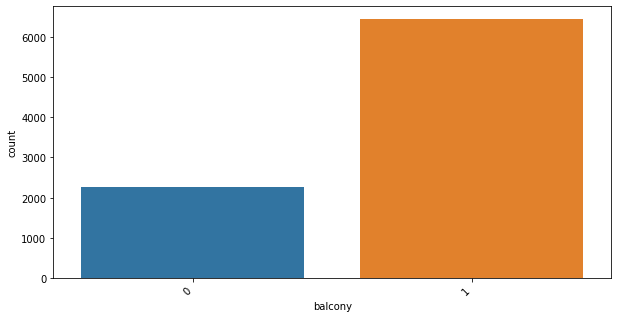

In [23]:
plotchart("balcony")

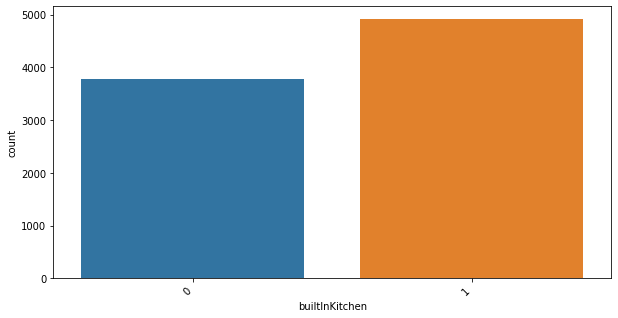

In [24]:
plotchart("builtInKitchen")

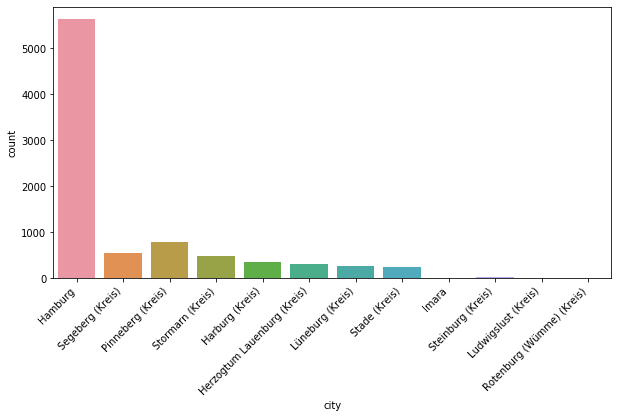

In [25]:
plotchart("city")

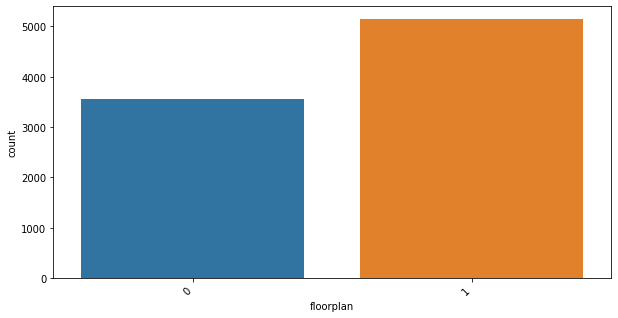

In [26]:
plotchart("floorplan")

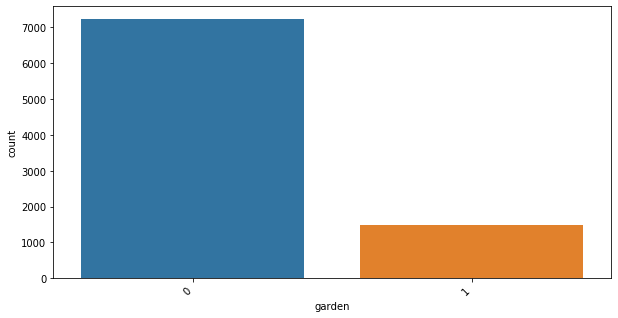

In [27]:
plotchart("garden")

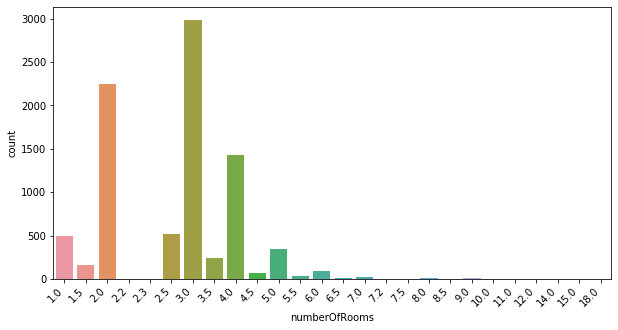

In [28]:
plotchart("numberOfRooms")

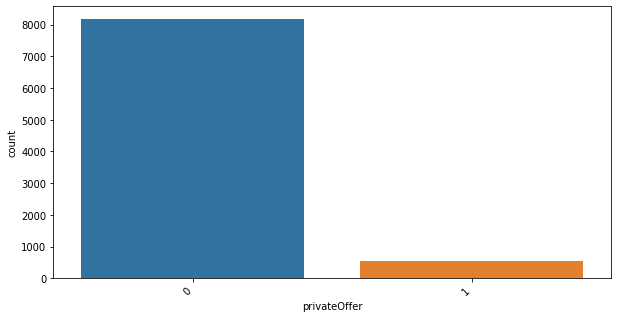

In [29]:
plotchart("privateOffer")

(array([8.044e+03, 4.560e+02, 1.220e+02, 5.000e+01, 1.500e+01, 6.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([7.0000e+03, 1.0013e+06, 1.9956e+06, 2.9899e+06, 3.9842e+06,
        4.9785e+06, 5.9728e+06, 6.9671e+06, 7.9614e+06, 8.9557e+06,
        9.9500e+06]),
 <a list of 10 Patch objects>)

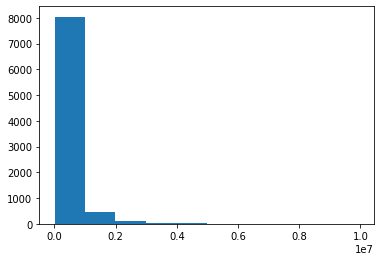

In [30]:
plt.hist(dfu["price"])

(array([4.593e+03, 3.332e+03, 5.540e+02, 1.460e+02, 5.000e+01, 1.000e+01,
        9.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([ 17.55 ,  80.795, 144.04 , 207.285, 270.53 , 333.775, 397.02 ,
        460.265, 523.51 , 586.755, 650.   ]),
 <a list of 10 Patch objects>)

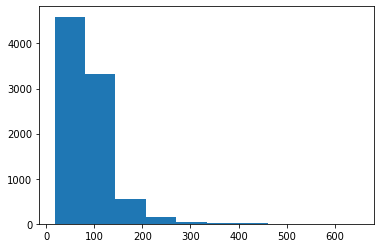

In [31]:
plt.hist(dfu["livingSpace"])

In [32]:
#creating a function that plots the sorted value counts per column for the top n elements

def plotcharttopn(column, n):
    
    plt.figure(figsize=(10,5))
    ch = sns.countplot(dfu[column], order=dfu[column].value_counts().iloc[:n].index)
    ch.set_xticklabels(ch.get_xticklabels(), rotation=45, horizontalalignment='right')

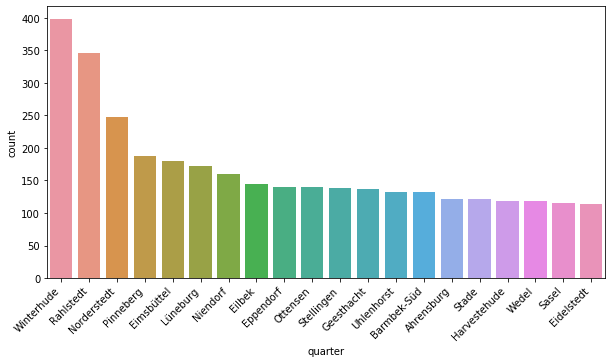

In [33]:
plotcharttopn("quarter", 20)

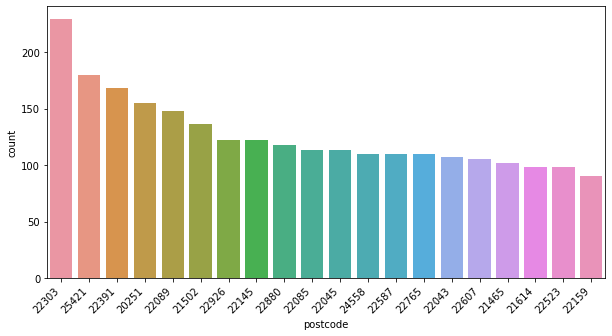

In [34]:
plotcharttopn("postcode", 20)

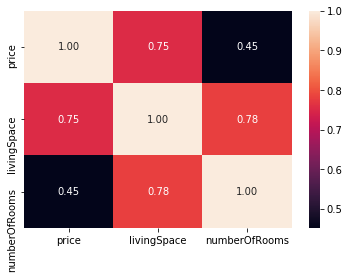

In [35]:
#checking numerical columns for correlation
sns.heatmap(dfu[["price", "livingSpace", "numberOfRooms"]].corr(), annot=True, fmt=".2f");

### Preparing data for medelling

In [36]:
#the postcode needs to be a string for one hot encoding
dfu["postcode"] = dfu["postcode"].astype(object)

In [37]:
cat_dfu = dfu[["postcode", "quarter", "city"]]

#One Hot Encoding the categorical columns
cat_dfu_dummies = pd.get_dummies(cat_dfu)
cat_dfu_dummies.head()

,postcode_19258,postcode_20087,postcode_20095,postcode_20097,postcode_20099,postcode_20144,postcode_20146,postcode_20148,postcode_20149,postcode_20249,...,city_Herzogtum Lauenburg (Kreis),city_Imara,city_Ludwigslust (Kreis),city_Lüneburg (Kreis),city_Pinneberg (Kreis),city_Rotenburg (Wümme) (Kreis),city_Segeberg (Kreis),city_Stade (Kreis),city_Steinburg (Kreis),city_Stormarn (Kreis)
ID,,,,,,,,,,,,,,,,,,,,,
107053440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109298032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108673845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108673576,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107298572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
num_dfu = dfu[["price", "livingSpace", "numberOfRooms"]]

In [39]:
bool_dfu = dfu[['balcony', 'builtInKitchen', 'floorplan', 'garden', 'privateOffer']]

In [40]:
#Combining the one hot encoded categorical columns with the numerical and bool columns.
dfu_mod = cat_dfu_dummies.join(num_dfu).join(bool_dfu)

In [41]:
dfu_mod.shape

(8698, 490)

### Modelling

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

#Split into explanatory and response variables
X = dfu_mod.drop(columns=['price'])
y = dfu_mod['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate model
ridge_model = Ridge()

#Get Model Parameters
ridge_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [43]:
#Instantiate parameters for GridSearchCV
parameters = {
    'alpha': [0.5, 1.0, 2.0],
    'solver': ['auto', 'svd'],
    'tol': [0.0005, 0.001, 0.002]
}

#Instantiate model
ridge_model = Ridge()

#GridSearc
cv = GridSearchCV(ridge_model, param_grid=parameters)

#Fit
cv.fit(X_train, y_train)

#Predict and score the model
y_test_preds_ridge = cv.predict(X_test)
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds_ridge), len(y_test))

'The r-squared score for the model was 0.7902860596190961 on 2610 values.'

In [44]:
cv.best_params_

{'alpha': 1.0, 'solver': 'auto', 'tol': 0.0005}

In [45]:
#Instantiate final model
model = Ridge(alpha=1.0,
 solver='auto',
 tol=0.0005)

#Fit
model.fit(X_train, y_train)

#Predict and score the model
y_test_preds_ridge = model.predict(X_test)
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds_ridge), len(y_test))

'The r-squared score for the model was 0.7902860596190961 on 2610 values.'

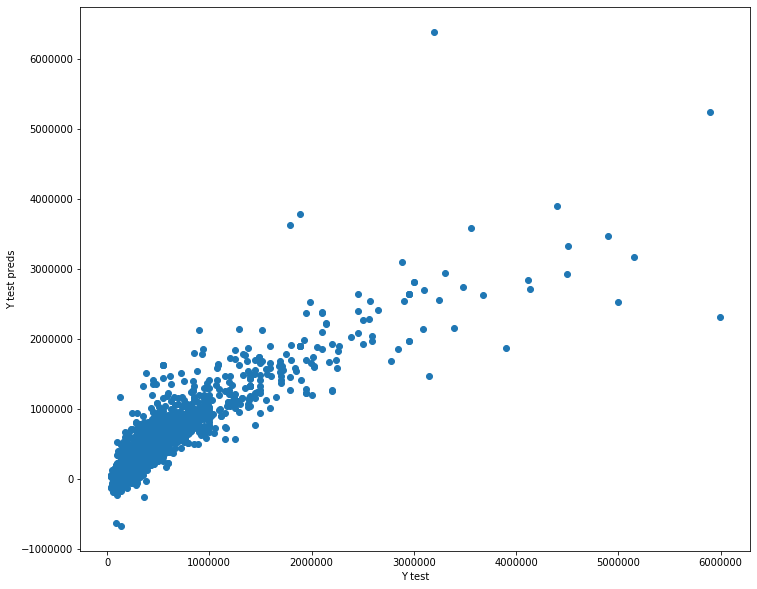

In [46]:
plt.figure(figsize=(12,10))
plt.scatter(y_test, y_test_preds_ridge)
plt.xlabel("Y test")
plt.ylabel("Y test preds")
plt.show()

### Checking the coefficients of the model

In [47]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['input_variable'] = X_train.columns
    coefs_df['coef'] = model.coef_
    coefs_df['abs_coef'] = np.abs(model.coef_)
    coefs_df = coefs_df.sort_values('abs_coef', ascending=False)
    return coefs_df

In [48]:
coef_df = coef_weights(model.coef_, X_train)

### 1. Which neighborhood has the highest impact?

In [49]:
coef_df[coef_df["input_variable"].str.startswith("postcode")].head(15)

,input_variable,coef,abs_coef
15,postcode_20354,890770.801446,890770.801446
24,postcode_20547,705068.933985,705068.933985
8,postcode_20149,520144.517952,520144.517952
7,postcode_20148,510370.647289,510370.647289
30,postcode_21037,-344768.674145,344768.674145
5,postcode_20144,-335036.354756,335036.354756
117,postcode_22301,306642.123879,306642.123879
116,postcode_22299,298222.964665,298222.964665
9,postcode_20249,276234.388230,276234.388230
33,postcode_21075,-261128.470860,261128.470860


In [50]:
coef_df[coef_df["input_variable"].str.startswith("quarter")].head(15)

,input_variable,coef,abs_coef
312,quarter_HafenCity,686506.894691,686506.894691
326,quarter_Harvestehude,535687.419762,535687.419762
450,quarter_Uhlenhorst,473921.775966,473921.775966
330,quarter_Heimfeld,-465570.725604,465570.725604
380,quarter_Moorrege,-411130.284215,411130.284215
335,quarter_Hoheluft-Ost,255108.148001,255108.148001
424,quarter_Seeth-Ekholt,-254865.715222,254865.715222
392,quarter_Nienstedten,229239.044106,229239.044106
364,quarter_Langenbek,-220842.460790,220842.460790
383,quarter_Münsterdorf,-213675.787898,213675.787898


In [51]:
coef_df[coef_df["input_variable"].str.startswith("city")].head(15)

,input_variable,coef,abs_coef
470,city_Hamburg,252266.030696,252266.030696
480,city_Steinburg (Kreis),-64497.089707,64497.089707
472,city_Herzogtum Lauenburg (Kreis),-60269.500239,60269.500239
478,city_Segeberg (Kreis),-42326.160711,42326.160711
481,city_Stormarn (Kreis),-38921.024508,38921.024508
475,city_Lüneburg (Kreis),-37684.838494,37684.838494
476,city_Pinneberg (Kreis),-15326.927704,15326.927704
479,city_Stade (Kreis),-15100.310036,15100.310036
477,city_Rotenburg (Wümme) (Kreis),9056.419823,9056.419823
474,city_Ludwigslust (Kreis),7945.382514,7945.382514


### 2. How do space and the number of rooms relate to the price?

In [52]:
coef_df[coef_df["input_variable"].str.startswith(("livingSpace", "numberOfRooms"))]

,input_variable,coef,abs_coef
483,numberOfRooms,-121532.219007,121532.219007
482,livingSpace,10365.092667,10365.092667


### 3. How do private offers impact the price?

In [53]:
coef_df[coef_df["input_variable"].str.startswith("privateOffer")]

,input_variable,coef,abs_coef
488,privateOffer,2023.693986,2023.693986


### 4. How do other factors impact the price?

In [54]:
coef_df[coef_df["input_variable"].str.startswith(("balcony", "builtInKitchen", "floorplan", "garden"))]

,input_variable,coef,abs_coef
484,balcony,13534.076329,13534.076329
485,builtInKitchen,-9897.808708,9897.808708
486,floorplan,-8412.400983,8412.400983
487,garden,-6859.523766,6859.523766
